In [1]:
import numpy as np
import pandas
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

## Constants

In [2]:
# file_path = "/nfs/lab/varpred/Final_Results/final_matrices/"
file_path = "./"
t1d_mat = file_path + "T1D_new_04_09_short.bed"
t2d_mat = file_path + "T2D_new_04_09_short.bed"
# topmed_mat = file_path + "topmed_final.bed"

# Automating Experiments

## Data Ingestion

In [3]:
# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')

# Splitting labels and data
t1d_labels_raw = t1d_data_raw["Probability"]
t1d_data_raw = t1d_data_raw.drop(['Locus', 'VarID', 'Probability'], axis=1)

# Filtering out variants with all 0s
print("Originally", len(t1d_data_raw), "variants.", "Filtering out", len(t1d_data_raw) - len(t1d_data_raw[(t1d_data_raw.T != 0).any()]), "variants; left with", len(t1d_data_raw[(t1d_data_raw.T != 0).any()]))

t1d_data = t1d_data_raw[(t1d_data_raw.T != 0).any()]  # Only non-zero variants
t1d_labels = t1d_labels_raw[t1d_labels_raw.index.isin(t1d_data.index)]  # Get matching labels

# Resetting index for splitting
t1d_data = t1d_data.reset_index(drop=True)
t1d_labels = t1d_labels.reset_index(drop=True)

Originally 31341 variants. Filtering out 0 variants; left with 31341


In [4]:
# Removing imbalance columns
t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'imbal' in col])

In [5]:
# Bin data
bin_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'bin' not in col])

# Non bin data
non_bin_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'bin' in col])

In [6]:
t1d_data = bin_data

## Dimensionality Reduction

In [7]:
pca = PCA(n_components=20)

## Label Spreading Model Tests

In [8]:
# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1
    
# Split unknown and known data
def sort_data(data, labels):
    known_data_bool = labels != -1
    all_data = data.copy(deep=True)
    all_data.insert(len(all_data.columns), 'label', labels)
    all_data.insert(len(all_data.columns), 'known', known_data_bool)
    all_known_data = all_data[all_data.known == True]
    all_unknown_data = all_data[all_data.known == False]
    known_data = all_known_data.drop(['label', 'known'], axis=1)
    known_labels = all_known_data['label']
    unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
    unknown_labels = all_unknown_data['label']
    
    return all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels


def create_splitter(all_known_data, unknown_data):
    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(all_known_data)

    def custom_splitter(splits):
        for train_index, test_index in splits:
            train_index = np.append(train_index, list(unknown_data.index.values))
            yield train_index, test_index
            
    return splits, custom_splitter


def perform_cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    splits, custom_splitter = create_splitter(all_known_data, unknown_data)
    cv_score = cross_val_score(model, data, y=labels, cv=custom_splitter(splits), verbose=1, n_jobs=1)
    return np.mean(cv_score)

def cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(known_data, known_labels)
    
    total_acc_score = 0
    total_prec_score = 0
    total_rec_score = 0
    total_fp_score = 0
    total_tp_score = 0
    total_tn_score = 0
    total_fn_score = 0
    num = 0
    for train_idx, test_idx in splits:
        train_data = known_data.iloc[train_idx].append(unknown_data)
        test_data = known_data.iloc[test_idx]
        train_labels = known_labels.iloc[train_idx].append(unknown_labels)
        test_labels = known_labels.iloc[test_idx]
        
        rus = RandomUnderSampler(random_state=42)
#         print("Test labels 0/1:", len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))
        test_data, test_labels = rus.fit_resample(test_data, test_labels)
#         print("After balance:", len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))

        model.fit(train_data, train_labels)

        # Predict on test
        pred_labels = model.predict(test_data)

        # Measure accuracy
        acc = accuracy_score(test_labels, pred_labels)
        prec = precision_score(test_labels, pred_labels)
        rec = recall_score(test_labels, pred_labels)
        total_acc_score += acc
        total_prec_score += prec
        total_rec_score += rec
        tn, fp, fn, tp = confusion_matrix(test_labels, pred_labels).ravel()
#         total_fp_score += (fp / (fp + tp))
#         total_tp_score += (tp / (fp + tp))
#         total_fn_score += (fn / (fn + tn))
#         total_tn_score += (tn / (fn + tn))
        total_fp_score += fp
        total_tp_score += tp
        total_fn_score += fn
        total_tn_score += tn
        num += 1
        
    total_fp_score = total_fp_score / num
    total_tp_score = total_tp_score / num
    total_fn_score = total_fn_score / num
    total_tn_score = total_tn_score / num
    
    fp_percent = total_fp_score / (total_fp_score + total_tp_score)
    tp_percent = total_tp_score / (total_fp_score + total_tp_score)
    fn_percent = total_fn_score / (total_fn_score + total_tn_score)
    tn_percent = total_tn_score / (total_fn_score + total_tn_score)

    print("Avg accuracy, precision, recall:", total_acc_score / num, total_prec_score / num, total_rec_score / num)
    print("fp, tp, tn, fn:", fp_percent, tp_percent, fn_percent, tn_percent)
    return total_acc_score / num, total_prec_score / num, total_rec_score / num, fp_percent, tp_percent, fn_percent, tn_percent

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

high_prob_thresholds = [0.01, 0.001, 0.0001]
low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
# high_prob_thresholds = [0.001]
# low_prob_thresholds = [0.000005]
# low_prob_thresholds = [0.00002, 0.000025, 0.00003]
# kernels = ['knn', 'rbf']
kernels = ['rbf']
# gammas = [30, 25, 20, 15, 10, 5]
# gammas = [25, 20, 15]
gammas = [20]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
# n_neighbors = [8, 7, 6]
n_neighbors = [7]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Kernel",
    "alpha",
    "gamma",
    "n_neighbors",
    "Average Accuracy Score",
    "Average Precision Score",
    "Average Recall Score",
    "Avg False Positives",
    "Avg True Positives",
    "Avg False Negatives", 
    "Average True Negatives"
]
res = pandas.DataFrame(columns=res_columns)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        # Label points based on prob thresholds
        print("high: ", prob_thresh_high, "low", prob_thresh_low, end=':')
        print("Positive", len(t1d_labels[t1d_labels > prob_thresh_high]), end='; ')
        print("Negative", len(t1d_labels[t1d_labels < prob_thresh_low]), end='; ')
        print("Unlabelled", len(t1d_labels[(t1d_labels <= prob_thresh_high) & (t1d_labels >= prob_thresh_low)]), end='; ')
        print("")
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        alphas += [prob_thresh_high]
        for alpha in alphas:
            for kernel in kernels:
                models = []
                if kernel == 'rbf':
                    for gamma in gammas:
                        model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma)
#                         norm_model = make_pipeline(pca, model)
#                         norm_model = make_pipeline(MinMaxScaler(), model)
                        norm_model = model
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, gamma, "N/A", acc, prec, rec, fp, tp, fn, tn]
                elif kernel == 'knn':
                    for neighbors in n_neighbors:
                        model = LabelSpreading(kernel="knn", alpha=alpha, n_neighbors=neighbors)
                        norm_model = make_pipeline(pca, model)
#                         norm_model = make_pipeline(MinMaxScaler(), model)
#                         norm_model = model
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, "N/A", neighbors, acc, prec, rec, fp, tp, fn, tn]

                else:
                    print("Error; invalid kernel")
                    continue

res.to_csv("./Results/4.09_data/rbf_results_bin_data.csv")           

high:  0.01 low 5e-06:Positive 869; Negative 613; Unlabelled 29859; 


In [24]:
t1d_res = res

In [16]:
t1d_res = pandas.read_csv('./Results/fixed_balanced_testing_rbf_results_bin_data_normalized.csv')
# t2d_res = pandas.read_csv('./Results/t2d_normalized_label_spreading.csv')

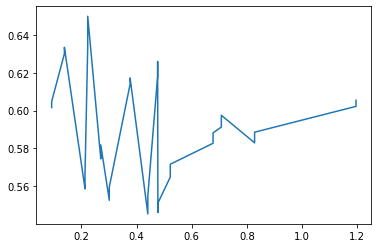

In [25]:
x = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

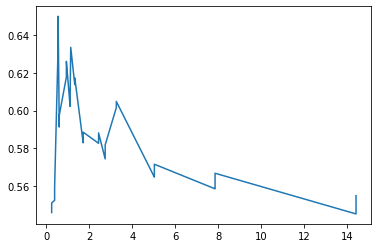

In [26]:
x = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

In [3]:
t1d_res = pandas.read_csv('./Results/t1d_ls_precision_accuracy_filtered.csv')

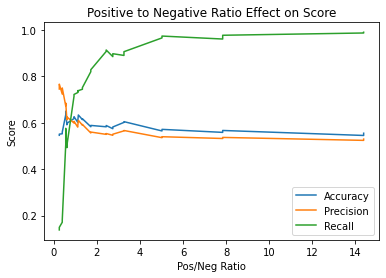

In [27]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

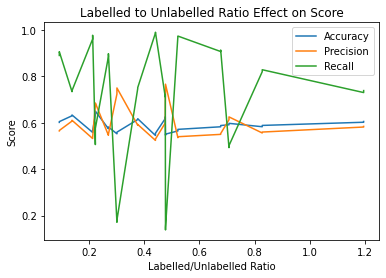

In [28]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

In [6]:
t1d_res = pandas.read_csv('./Results/t1d_ls_precision_accuracy_filtered_tp_fp.csv')

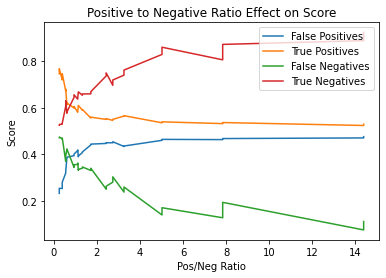

In [29]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
x4 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

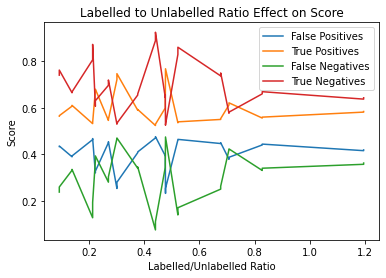

In [30]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
x4 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

# Compare Limited Data to Prev

In [19]:
all_data_res = pandas.read_csv('./Results/balanced_testing_rbf_results_PCA_20_components.csv')
bin_data_res = pandas.read_csv('./Results/balanced_testing_rbf_results_PCA_20_components_bin_data.csv')

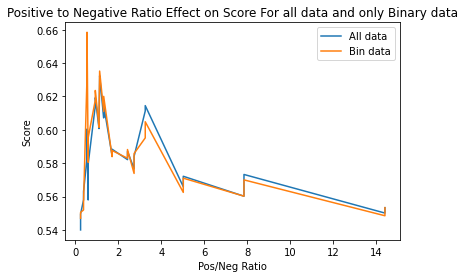

In [25]:
x = all_data_res["Pos/Neg ratio"]
# x2 = all_data_res["Pos/Neg ratio"]
# x3 = all_data_res["Pos/Neg ratio"]
x2 = bin_data_res["Pos/Neg ratio"]
y = all_data_res['Average Accuracy Score']
# y2 = all_data_res['Average Precision Score']
# y3 = all_data_res['Average Recall Score']
y2 = bin_data_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='All data')
plt.plot(x2, y2, label='Bin data')
plt.title("Positive to Negative Ratio Effect on Score For all data and only Binary data")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

In [26]:
max(all_data_res['Average Accuracy Score'])

0.6323863636363637

In [27]:
max(bin_data_res['Average Accuracy Score'])

0.6585

In [6]:
pandas.read_csv(t1d_mat, sep="\s+")

,Locus,VarID,Probability,Acinar_peaks_bin,Alpha_peaks_bin,Beta_peaks_bin,Delta_peaks_bin,Ductal_peaks_bin,Endo_peaks_bin,Gamma_peaks_bin,...,TFA,THA,TP5,TP6,USF,YY1.like,ZEB,ZFX.ZFY,ZNF,ZNF76.like
0,BCL11A_2:60260984:C:T,2:60136527:T:C,0.000028,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BCL11A_2:60260984:C:T,2:60137193:C:T,0.000009,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BCL11A_2:60260984:C:T,2:60137630:G:A,0.002636,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BCL11A_2:60260984:C:T,2:60142688:T:G,0.004140,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BCL11A_2:60260984:C:T,2:60143175:C:T,0.000014,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12375,PTPN2_18:12818922:G:A,18:12805388:G:A,0.292516,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12376,PTPN2_18:12857758:G:A,18:12857758:G:A,0.593261,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12377,PTPN22_1:114377568:A:G,1:114377568:A:G,1.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12378,TYK2_19:10463118:G:C,19:10463118:G:C,0.999905,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
